## Spatial Overlays
A spatial overlay is the process of superimposing layers of geographic data that cover the same area to study the relationship between them. -- [ESRI](https://support.esri.com/en/other-resources/gis-dictionary/term/spatial%20overlay) 

They allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new Geoframe with the new geometries representing the spatial combination and merged properties.

This allows you to answer question like: What roads are within what boroughs?

There are different types of overlays that can be done, the basic idea for each is shown in the graphic below. 
![overlay operations](http://docs.qgis.org/testing/en/_images/overlay_operations.png)

Now we can load up two GeoDataFrames containing (multi)polygon geometries...

The data for this practice will be NYC borough shape files and the wi-fi hotspot locations:
 * [NYC Borough Boundaries](https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile) - See it in action [here](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
 
 * [NYC Wi-Fi Hotspot Locations](https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=Shapefile) - See it in action [here](https://data.cityofnewyork.us/Social-Services/NYC-Wi-Fi-Hotspot-Locations/a9we-mtpn)



In [2]:
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
from random import randint, uniform
import matplotlib.pyplot as plt

import urllib.request
import shutil
from pathlib import Path
from zipfile import ZipFile

import geopandas as gpd

## Loading NYC Boroughs and Wi-FI Data

In [3]:
# Designate the URL for a file
file_URL = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'

# Designate the local filename
local_file_name = 'nyc_boroughs.zip'

# Designate the local file name with a path to a temp directory.
     # Your Repo comes with this folder.  If not, use terminal and 
     # navigate to course folder > module3 and them : mkdir temp
file_Path = Path('../temp/')  
file_Path /= local_file_name

# Download the file from `url` and save it locally under `file_Path`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)

# unzip file
to_unzip = ZipFile('../temp/nyc_boroughs.zip', 'r')
unzipped = '../temp/nyc_boroughs_unzipped'
to_unzip.extractall(unzipped)
to_unzip.close()
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file

NYC = gpd.GeoDataFrame.from_file(shape_file)        

In [4]:
# Designate the URL for a file
file_URL = 'https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=Shapefile'

# Designate the local filename
local_file_name = 'nyc_wifi.zip'

# Designate the local file name with a path to a temp directory.
     # Your Repo comes with this folder.  If not, use terminal and 
     # navigate to course folder > module3 and them : mkdir temp
file_Path = Path('../temp/')  
file_Path /= local_file_name

# Download the file from `url` and save it locally under `file_Path`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)

# unzip file
to_unzip = ZipFile('../temp/nyc_wifi.zip', 'r')
unzipped = os.getcwd() + '/nyc_wifi_unzipped'
to_unzip.extractall(unzipped)
to_unzip.close()
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file

# Read data into GeoDataFrame and view data
NYC_wifi = gpd.GeoDataFrame.from_file(shape_file)

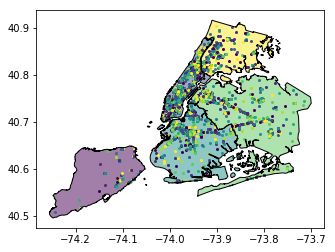

In [5]:
NYC.plot(ax=NYC_wifi.plot())    

### A little data munging for the purpose of this example
As noted earlier, overlays compare two GeoDataFrames containing polygon or multipolygon geometries. Currently, we do not have this, as the NYC Wi-Fi Hotspot Locations consists of point geometries and not polys. 
So for the purposes of this example only, I am going to take the points and create polys for each location. Imagine if you will that the polys represent the footprint of each Wi-Fi network. 

In [8]:
NYC_wifi_poly = NYC_wifi
NYC_wifi_poly['geometry'] = NYC_wifi.buffer(.002)

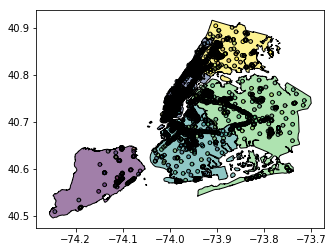

In [9]:
NYC.plot(ax=NYC_wifi_poly.plot())

### Overlay Function

Now that we have that out of the way, let's take a closer look at the overlay function within Geopandas.

The geopandas.tools.overlay function takes three arguments:
* dataframe 1
* dataframe 2
* how

Where "how" can be one of:
['intersection',
'union',
'identity',
'symmetric_difference',
'difference']

Keep in mind that overlays operate at the dataframe level, not on individual geometries, and the properties from both are retained. 

So let's identify the areas (and attributes) where the dataframes intersect using the overlay tool.

*Note this takes a bit to run.*

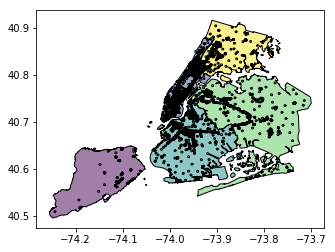

In [9]:
from geopandas.tools import overlay
Interdf = overlay(NYC_wifi_poly, NYC, how="intersection")
Interdf.plot(ax=NYC.plot())

Now lets look at the orginal data frams and then the new data frame. Notice that in the new data frame we see that the attributes from both of the original GeoDataFrames are retained.

In [10]:
NYC.head()

,boro_code,boro_name,geometry,shape_area,shape_leng
0,5.0,Staten Island,(POLYGON ((-74.05050806403247 40.5664220341608...,1.623914e+09,330434.340939
1,1.0,Manhattan,(POLYGON ((-74.01092841268031 40.6844914725429...,6.366004e+08,361657.416718
2,3.0,Brooklyn,(POLYGON ((-73.86706149472118 40.5820879767934...,1.937596e+09,741150.814455
3,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
4,2.0,Bronx,(POLYGON ((-73.89680883223774 40.7958084451597...,1.186619e+09,463454.790585


In [11]:
NYC_wifi_poly.head()

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,objectid,postcode,provider,remarks,sourceid,ssid,time_activ,type,x,y
0,0.000000e+00,0.0,MN,105.0,1.0,1009500.0,Manhattan,New York,3.0,95.0,...,998.0,10001.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-008695,LinkNYC Free Wi-Fi,00:00:00.000,Free,985901.695307,211053.130644
1,1.008590e+09,1016929.0,MN,105.0,1.0,1007400.0,Manhattan,New York,2.0,74.0,...,999.0,10016.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-014013,LinkNYC Free Wi-Fi,00:00:00.000,Free,988387.309473,210559.946684
2,1.010160e+09,1024714.0,MN,105.0,1.0,1011900.0,Manhattan,New York,3.0,119.0,...,1000.0,10036.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-007083,LinkNYC Free Wi-Fi,00:00:00.000,Free,988162.256449,215315.021263
3,1.010200e+09,1076195.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,1001.0,10036.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-003309,LinkNYC Free Wi-Fi,00:00:00.000,Free,988587.757617,216155.033448
4,1.010208e+09,1087187.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,1002.0,10019.0,LinkNYC - Citybridge,"Tablet Internet -phone , Free 1 GB Wi-FI Service",LINK-000162,LinkNYC Free Wi-Fi,00:00:00.000,Free,988532.655360,216316.036881


In [12]:
Interdf.head()

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,ssid,time_activ,type,x,y,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.078990e+09,5088113.0,SI,503.0,5.0,5024401.0,Staten Island,Staten Island,51.0,24401.0,...,NYPL,00:00:00.000,Free,916370.601298,125007.163094,5.0,Staten Island,1.623914e+09,330434.340939,POLYGON ((-74.24210670826179 40.50953112385938...
1,5.065960e+09,0.0,SI,503.0,5.0,5019800.0,Staten Island,Staten Island,51.0,198.0,...,GuestWiFi,00:00:00.000,Limited Free,931332.300378,127707.548113,5.0,Staten Island,1.623914e+09,330434.340939,POLYGON ((-74.18993635033875 40.51508290534463...
2,5.065960e+09,0.0,SI,503.0,5.0,5019800.0,Staten Island,Staten Island,51.0,198.0,...,GuestWiFi,00:00:00.000,Limited Free,931332.300378,127707.548113,5.0,Staten Island,1.623914e+09,330434.340939,POLYGON ((-74.18987260316322 40.51515043694479...
3,5.065960e+09,0.0,SI,503.0,5.0,5019800.0,Staten Island,Staten Island,51.0,198.0,...,GuestWiFi,00:00:00.000,Limited Free,931332.300378,127707.548113,5.0,Staten Island,1.623914e+09,330434.340939,"POLYGON ((-74.19062663672626 40.5153183412299,..."
4,5.068170e+09,5083401.0,SI,503.0,5.0,5020804.0,Staten Island,Staten Island,51.0,20804.0,...,NYPL,00:00:00.000,Free,930535.801971,133907.647917,5.0,Staten Island,1.623914e+09,330434.340939,POLYGON ((-74.19123685600897 40.53405829989932...


Because both of our orignal datasets cover all of NYC area, when we ran the intersection you probably noticed that we got all of the wifi hotspots and all of the boroughs. Remember overlays operate at the dataframe level, not on individual geometries, and the properties from both are retained.

Let's break down the borough data into the individual boroughs to get a better visualization of what is going on with the overlays.

In [10]:
Staten_Island = NYC[NYC['boro_name'] == 'Staten Island']
Manhattan = NYC[NYC['boro_name'] == 'Manhattan']
Brooklyn = NYC[NYC['boro_name'] == 'Brooklyn']
Queens = NYC[NYC['boro_name'] == 'Queens']
Bronx = NYC[NYC['boro_name'] == 'Bronx']

## Intersection 
The resulting geodataframe includes all polygon parts that occur in both input layers and all other parts are excluded. It is roughly analogous to AND in logic and multiplication in arithmetic.

In [ ]:
from geopandas.tools import overlay
Interdf = overlay(NYC_wifi_poly, Manhattan, how="intersection")
Interdf.plot(ax=NYC.plot())

Now it is your turn. Below is what each of the other "how" options in the overlay function do. Please explore them and their results until you feel comfortable which each of them.

## Union 
The resulting geodataframe includes all polygon parts that occur in either A or B (or both), thus is the sum of all the parts of both A and B. Different from "identify" in that individual layers are no longer identifiable. It is roughly analogous to OR in logic and addition in arithmetic.

## Symmetric Difference
The result geodataframe includes polygons that occur in one of the layers but not both. It can be derived as either (A union B) subtract (A intersect B), or (A subtract B) union (B subtract A). It is roughly analogous to XOR in logic.

## Identity 
The resulting geodataframe covers the extent of one of the two layers, with the geometery and attributes merged in the area where they overlap. It can be derived as (A subtract B) union (A intersect B).

## Difference 
The resulting geodataframe includes only those polygon parts that occur in one layer but not in another. It is roughly analogous to AND NOT in logic and subtraction in arithmetic.

## Conclusion
This lab covered:
* Vector overlays using the geopanda overlay function 